In [154]:
import pandas as pd

# load all the data files
agency = pd.read_csv('agency.txt')
calendar = pd.read_csv('calendar.txt')
routes = pd.read_csv('routes.txt')
shapes = pd.read_csv('shapes.txt')
stop_times = pd.read_csv('stop_times.txt')
stops = pd.read_csv('stops.txt')
trips = pd.read_csv('trips.txt')

# show the first few rows and the structure of each dataframe
data_overviews = {
    "agency": agency.head(),
    "calendar": calendar.head(),
    "routes": routes.head(),
    "shapes": shapes.head(),
    "stop_times": stop_times.head(),
    "stops": stops.head(),
    "trips": trips.head()
}

data_overviews

{'agency':   agency_id                   agency_name                      agency_url  \
 0      DMRC  Delhi Metro Rail Corporation  http://www.delhimetrorail.com/   
 
   agency_timezone  agency_lang  agency_phone  agency_fare_url  agency_email  
 0    Asia/Kolkata          NaN           NaN              NaN           NaN  ,
 'calendar':   service_id  monday  tuesday  wednesday  thursday  friday  saturday  sunday  \
 0    weekday       1        1          1         1       1         0       0   
 1   saturday       0        0          0         0       0         1       0   
 2     sunday       0        0          0         0       0         0       1   
 
    start_date  end_date  
 0    20190101  20251231  
 1    20190101  20251231  
 2    20190101  20251231  ,
 'routes':    route_id  agency_id route_short_name  \
 0        33        NaN           R_SP_R   
 1        31        NaN           G_DD_R   
 2        29        NaN           P_MS_R   
 3        12        NaN             M_JB

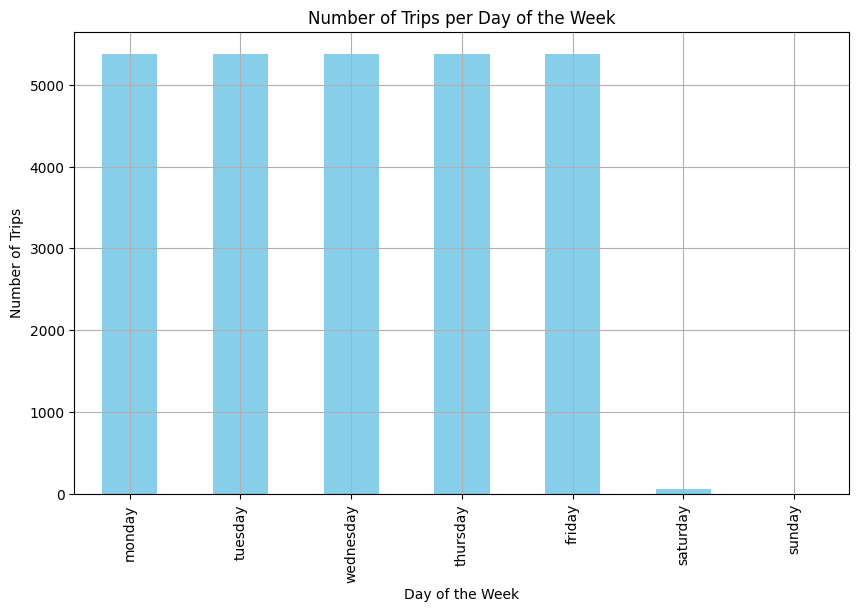

In [155]:
# merge trips with calendar to include the day of operation information
trips_calendar = pd.merge(trips, calendar, on='service_id', how='inner')

# count the number of trips per day of the week
trip_counts = trips_calendar[['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']].sum()

# Plotting
plt.figure(figsize=(10, 6))
trip_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Trips per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()

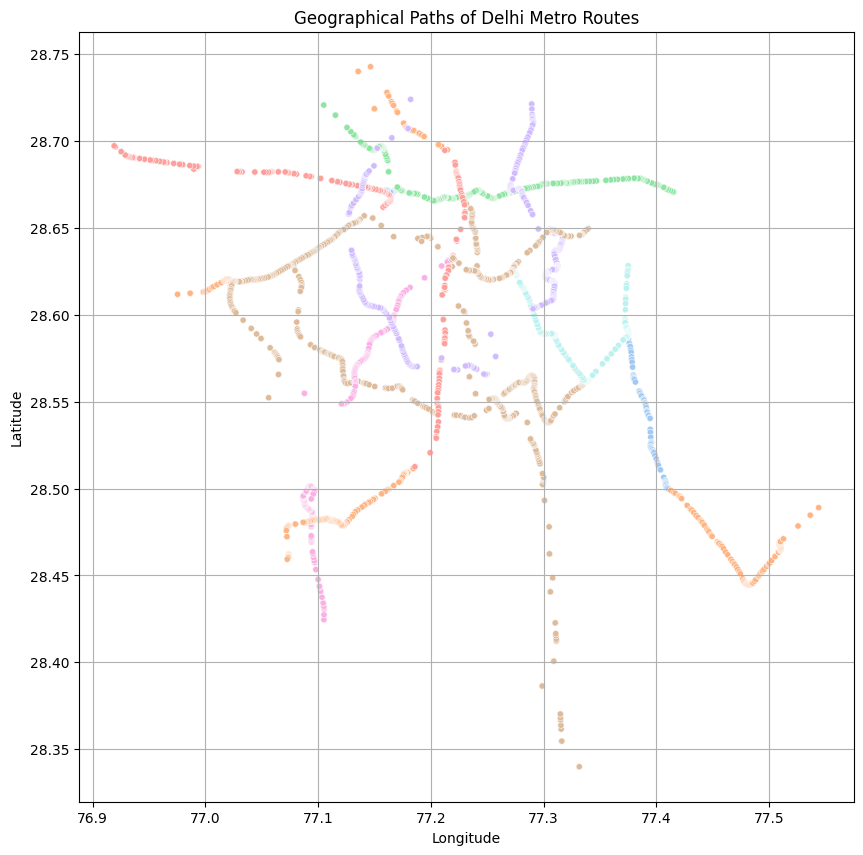

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.scatterplot(x='shape_pt_lon', y='shape_pt_lat', hue='shape_id', data=shapes, palette='pastel', s=20, legend=None)
plt.title('Geographical Paths of Delhi Metro Routes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

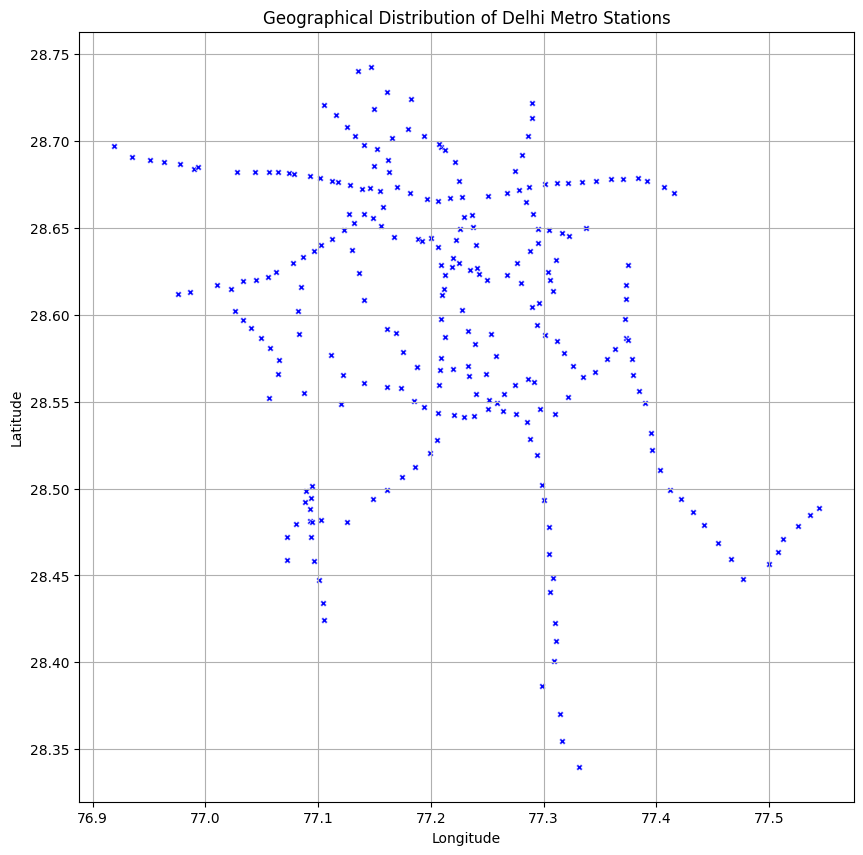

In [157]:
# plotting the locations of the stops
plt.figure(figsize=(10, 10))
sns.scatterplot(x='stop_lon', y='stop_lat', data=stops, color='Blue', s=20, marker='X')
plt.title('Geographical Distribution of Delhi Metro Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

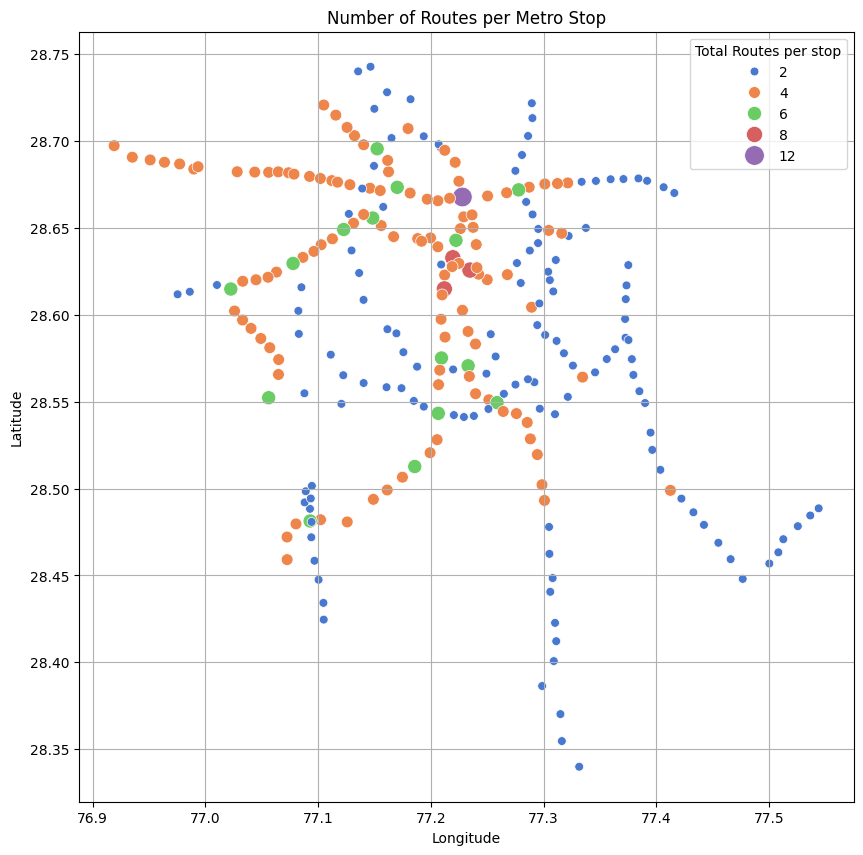

In [158]:
# merge stops with stop_times to link each stop with trips, and then merge with trips to get route information
stops_with_routes = pd.merge(pd.merge(stop_times, trips, on='trip_id'), routes, on='route_id')

# count how many unique routes pass through each stop
stop_route_counts = stops_with_routes.groupby('stop_id')['route_id'].nunique().reset_index()
stop_route_counts = stop_route_counts.rename(columns={'route_id': 'number_of_routes'})

# merge this with stops to get the names and location for plotting
stop_route_counts = pd.merge(stop_route_counts, stops, on='stop_id')

# plot the number of routes per stop
plt.figure(figsize=(10, 10))
sns.scatterplot(x='stop_lon', y='stop_lat', size='number_of_routes', hue='number_of_routes', sizes=(40, 200), palette='muted', data=stop_route_counts)
plt.title('Number of Routes per Metro Stop')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Total Routes per stop')
plt.grid(True)
plt.show()

C:\Users\Ayush\AppData\Local\Temp\ipykernel_12212\1831564914.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stop_times_intervals['part_of_day'] = stop_times_intervals['arrival_time_dt'].apply(part_of_day)


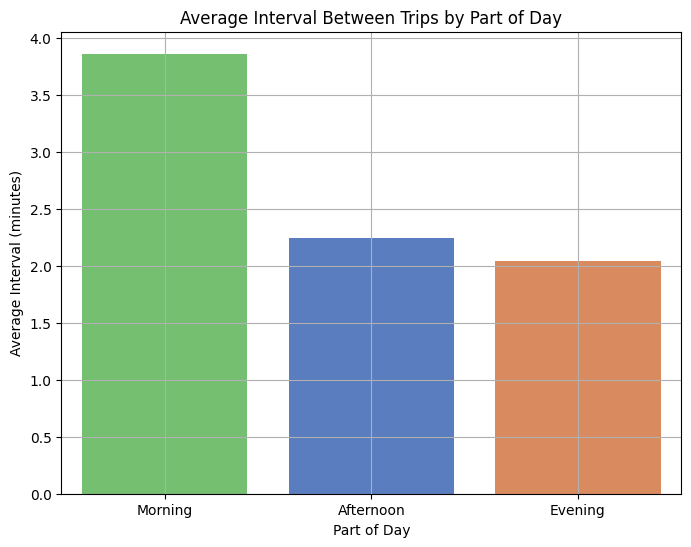

In [159]:
# converting stop_times 'arrival_time' from string to datetime.time for easier manipulation
import datetime as dt

# function to convert time string to datetime.time
def convert_to_time(time_str):
    try:
        return dt.datetime.strptime(time_str, '%H:%M:%S').time()
    except ValueError:
        # Handle cases where the hour might be greater than 23 (e.g., 24:00:00 or 25:00:00)
        hour, minute, second = map(int, time_str.split(':'))
        return dt.time(hour % 24, minute, second)

stop_times['arrival_time_dt'] = stop_times['arrival_time'].apply(convert_to_time)

# calculate the difference in arrival times for subsequent trips at each stop
stop_times_sorted = stop_times.sort_values(by=['stop_id', 'arrival_time_dt'])
stop_times_sorted['next_arrival_time'] = stop_times_sorted.groupby('stop_id')['arrival_time_dt'].shift(-1)

# function to calculate the difference in minutes between two times
def time_difference(time1, time2):
    if pd.isna(time1) or pd.isna(time2):
        return None
    full_date_time1 = dt.datetime.combine(dt.date.today(), time1)
    full_date_time2 = dt.datetime.combine(dt.date.today(), time2)
    return (full_date_time2 - full_date_time1).seconds / 60

stop_times_sorted['interval_minutes'] = stop_times_sorted.apply(lambda row: time_difference(row['arrival_time_dt'], row['next_arrival_time']), axis=1)

# drop NaN values from intervals (last trip of the day)
stop_times_intervals = stop_times_sorted.dropna(subset=['interval_minutes'])

# average intervals by time of day (morning, afternoon, evening)
def part_of_day(time):
    if time < dt.time(12, 0):
        return 'Morning'
    elif time < dt.time(17, 12):
        return 'Afternoon'
    else:
        return 'Evening'

stop_times_intervals['part_of_day'] = stop_times_intervals['arrival_time_dt'].apply(part_of_day)
average_intervals = stop_times_intervals.groupby('part_of_day')['interval_minutes'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='part_of_day', y='interval_minutes', data=average_intervals, hue='part_of_day', order=['Morning', 'Afternoon', 'Evening'], palette='muted')
plt.title('Average Interval Between Trips by Part of Day')
plt.xlabel('Part of Day')
plt.ylabel('Average Interval (minutes)')
plt.grid(True)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

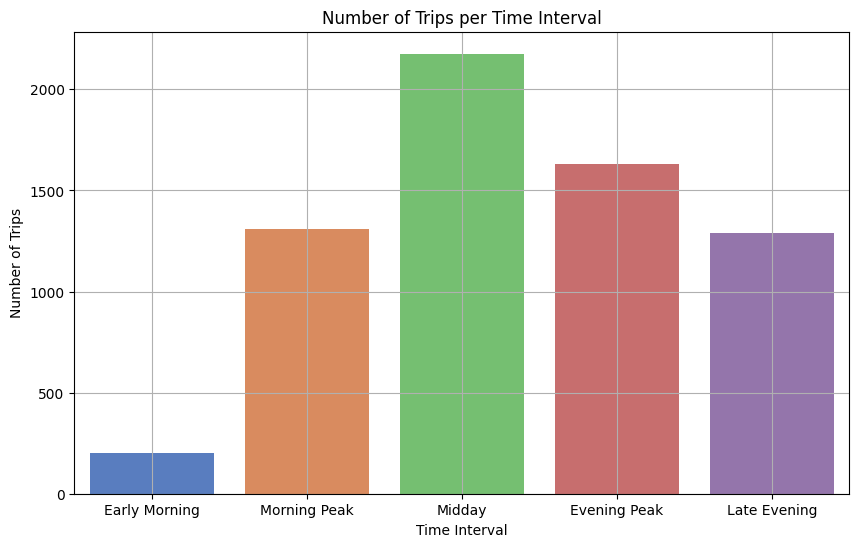

In [160]:
# define time intervals for classification
def classify_time_interval(time):
    if time < dt.time(6, 0):
        return 'Early Morning'
    elif time < dt.time(10, 6):
        return 'Morning Peak'
    elif time < dt.time(16, 10):
        return 'Midday'
    elif time < dt.time(20, 16):
        return 'Evening Peak'
    else:
        return 'Late Evening'

# apply time interval classification
stop_times['time_interval'] = stop_times['arrival_time_dt'].apply(classify_time_interval)

# count the number of trips per time interval
trips_per_interval = stop_times.groupby('time_interval')['trip_id'].nunique().reset_index()
trips_per_interval = trips_per_interval.rename(columns={'trip_id': 'number_of_trips'})

# sorting the dataframe
ordered_intervals = ['Early Morning', 'Morning Peak', 'Midday', 'Evening Peak', 'Late Evening']
trips_per_interval['time_interval'] = pd.Categorical(trips_per_interval['time_interval'], categories=ordered_intervals, ordered=True)
trips_per_interval = trips_per_interval.sort_values('time_interval')

# plotting the number of trips per time interval
plt.figure(figsize=(10, 6))
sns.barplot(x='time_interval', y='number_of_trips', hue='time_interval', data=trips_per_interval, palette='muted')
plt.title('Number of Trips per Time Interval')
plt.xlabel('Time Interval')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show

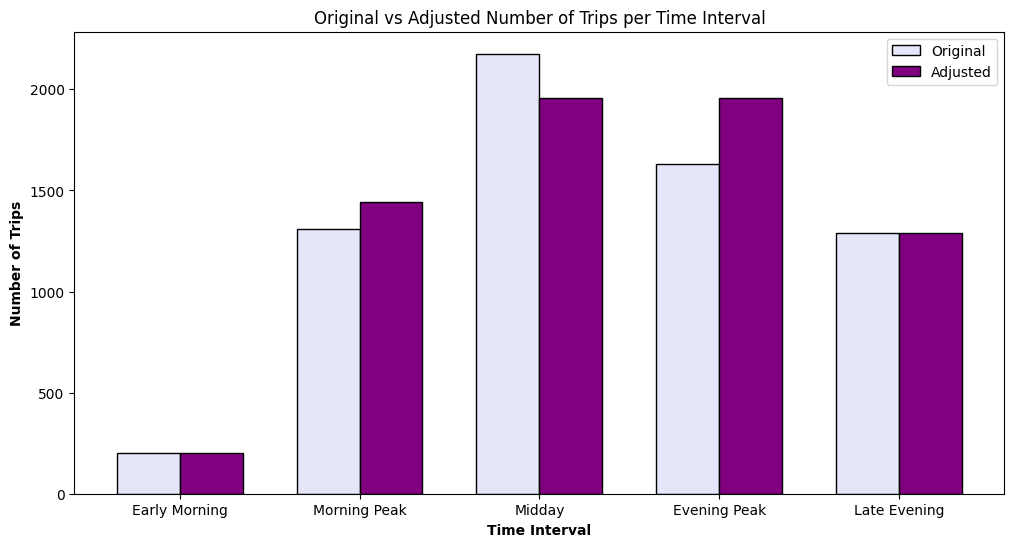

In [161]:
# adjusting frequencies based on hypothetical scenario
adjusted_trips_per_interval = trips_per_interval.copy()
adjustment_factors = {'Morning Peak': 1.10, 'Evening Peak': 1.20, 'Midday': 0.9, 'Early Morning': 1.0, 'Late Evening': 1.0}

# apply the adjustments
adjusted_trips_per_interval['adjusted_number_of_trips'] = adjusted_trips_per_interval.apply(
    lambda row: int(row['number_of_trips'] * adjustment_factors[row['time_interval']]), axis=1)

# plotting original vs adjusted number of trips per time interval
plt.figure(figsize=(12, 6))
bar_width = 0.35
r1 = range(len(adjusted_trips_per_interval))
r2 = [x + bar_width for x in r1]

plt.bar(r1, adjusted_trips_per_interval['number_of_trips'], color='lavender', width=bar_width, edgecolor='black', label='Original')
plt.bar(r2, adjusted_trips_per_interval['adjusted_number_of_trips'], color='purple', width=bar_width, edgecolor='black', label='Adjusted')

plt.xlabel('Time Interval', fontweight='bold')
plt.ylabel('Number of Trips', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(adjusted_trips_per_interval))], adjusted_trips_per_interval['time_interval'])
plt.title('Original vs Adjusted Number of Trips per Time Interval')
plt.legend()

plt.show()

In [162]:
'THANK YOU'

'THANK YOU'